# Training a Timm model with Batch Normalization

In [2]:
# Ensure fallback is enabled
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

In [1]:
# Imports
from typing import Optional, List

import torch
import torch.nn as nn
import torch.nn.functional as F

from timm import create_model

from fastai.vision.all import *
from fastai.callback.wandb import *
from fastai import *
import wandb

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Defining the U-net

In [2]:
class Conv2dBnAct(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding=0,
                 stride=1, act_layer=nn.ReLU, norm_layer=nn.BatchNorm2d):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=False)
        self.bn = norm_layer(out_channels)
        self.act = act_layer(inplace=True)
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x

In [3]:
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, scale_factor=2.0, act_layer=nn.ReLU, norm_layer=nn.BatchNorm2d):
        super().__init__()
        conv_args = dict(kernel_size=3, padding=1, act_layer=act_layer)
        self.scale_factor = scale_factor
        if norm_layer is None:
            self.conv1 = Conv2dBnAct(in_channels, out_channels, **conv_args)
            self.conv2 = Conv2dBnAct(out_channels, out_channels,  **conv_args)
        else:
            self.conv1 = Conv2dBnAct(in_channels, out_channels, norm_layer=norm_layer, **conv_args)
            self.conv2 = Conv2dBnAct(out_channels, out_channels, norm_layer=norm_layer, **conv_args)

    def forward(self, x, skip: Optional[torch.Tensor] = None):
        if self.scale_factor != 1.0:
            x = F.interpolate(x, scale_factor=self.scale_factor, mode='nearest')
        if skip is not None:
            x = torch.cat([x, skip], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

In [4]:
class UnetDecoder(nn.Module):

    def __init__(
            self,
            encoder_channels,
            decoder_channels=(256, 128, 64, 32, 16),
            final_channels=1,
            norm_layer=nn.BatchNorm2d,
            center=False,
    ):
        super().__init__()

        if center:
            channels = encoder_channels[0]
            self.center = DecoderBlock(channels, channels, scale_factor=1.0, norm_layer=norm_layer)
        else:
            self.center = nn.Identity()

        in_channels = [in_chs + skip_chs for in_chs, skip_chs in zip(
            [encoder_channels[0]] + list(decoder_channels[:-1]),
            list(encoder_channels[1:]) + [0])]
        out_channels = decoder_channels

        self.blocks = nn.ModuleList()
        for in_chs, out_chs in zip(in_channels, out_channels):
            self.blocks.append(DecoderBlock(in_chs, out_chs, norm_layer=norm_layer))
        self.final_conv = nn.Conv2d(out_channels[-1], final_channels, kernel_size=(1, 1))

        self._init_weight()

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def forward(self, x: List[torch.Tensor]):
        encoder_head = x[0]
        skips = x[1:]
        x = self.center(encoder_head)
        for i, b in enumerate(self.blocks):
            skip = skips[i] if i < len(skips) else None
            x = b(x, skip)
        x = self.final_conv(x)
        return x

In [5]:
class Unet(nn.Module):
    """Unet is a fully convolution neural network for image semantic segmentation
    Args:
        encoder_name: name of classification model (without last dense layers) used as feature
            extractor to build segmentation model.
        encoder_weights: one of ``None`` (random initialization), ``imagenet`` (pre-training on ImageNet).
        decoder_channels: list of numbers of ``Conv2D`` layer filters in decoder blocks
        decoder_use_batchnorm: if ``True``, ``BatchNormalisation`` layer between ``Conv2D`` and ``Activation`` layers
            is used.
        num_classes: a number of classes for output (output shape - ``(batch, classes, h, w)``).
        center: if ``True`` add ``Conv2dReLU`` block on encoder head
    NOTE: This is based off an old version of Unet in https://github.com/qubvel/segmentation_models.pytorch
    """

    def __init__(
            self,
            backbone='resnet50',
            backbone_kwargs=None,
            backbone_indices=None,
            decoder_use_batchnorm=True,
            decoder_channels=(256, 128, 64, 32, 16),
            in_chans=1,
            num_classes=5,
            center=False,
            norm_layer=nn.BatchNorm2d,
    ):
        super().__init__()
        backbone_kwargs = backbone_kwargs or {}
        # NOTE some models need different backbone indices specified based on the alignment of features
        # and some models won't have a full enough range of feature strides to work properly.
        encoder = create_model(
            backbone, features_only=True, out_indices=backbone_indices, in_chans=in_chans,
            pretrained=True, **backbone_kwargs)
        encoder_channels = encoder.feature_info.channels()[::-1]
        self.encoder = encoder

        if not decoder_use_batchnorm:
            norm_layer = None
        self.decoder = UnetDecoder(
            encoder_channels=encoder_channels,
            decoder_channels=decoder_channels,
            final_channels=num_classes,
            norm_layer=norm_layer,
            center=center,
        )

    def forward(self, x: torch.Tensor):
        x = self.encoder(x)
        x.reverse()  # torchscript doesn't work with [::-1]
        x = self.decoder(x)
        return x

In [6]:
# Defineing dice score metric
def dice(input, targs, iou=False, eps=1e-8,sz=256):
    #threshold for the number of predicted pixels
    noise_th = 75.0*(sz/128.0)**2 
    best_thr0 = 0.2
    n = targs.shape[0]
    #input = torch.softmax(input, dim=1)[:,1,...].view(n,-1)
    input = torch.sigmoid(input).view(n,-1)
    input = (input > best_thr0).long()
    input[input.sum(-1) < noise_th,...] = 0.0 
    targs = targs.view(n,-1)
    intersect = (input * targs).sum(-1).float()
    union = (input+targs).sum(-1).float()
    if not iou: return ((2.0*intersect + eps) / (union+eps)).mean()
    else: return ((intersect + eps) / (union - intersect + eps)).mean()

# Load data

In [7]:
data_path = Path('dataset/')
size=256
bs=64
def get_data(size,tfms=None,bs=64):
    if not tfms:
        tfms = [IntToFloatTensor(div_mask=255),*aug_transforms()]
    db = DataBlock(blocks=(ImageBlock(),MaskBlock()),
                   splitter=RandomSplitter(valid_pct=0.1,seed=2021),
                   batch_tfms=tfms,
                   item_tfms=[Resize(size)],
                   get_items=get_image_files,get_y=lambda o:str(o).replace('images','labels'))
    return db.dataloaders(source=data_path/'train'/'images',bs=bs)

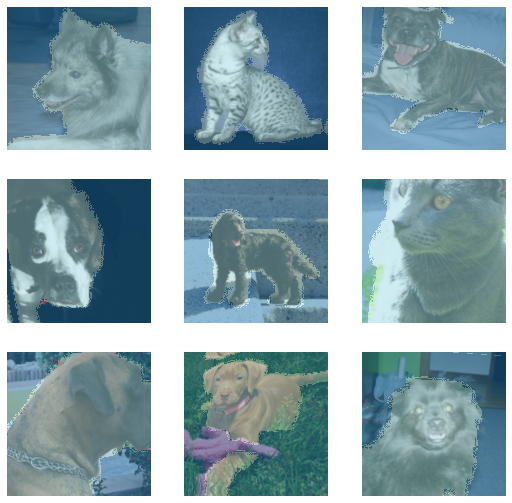

In [9]:
dls = get_data(size=256,bs=64)
dls.show_batch(max_n=9)

# Train the model

## Sanity check with pet segmentation

In [32]:
# All images
dls = get_data(size=256,bs=32)
learn = Learner(dls,Unet(backbone='resnet50', decoder_use_batchnorm=True, in_chans=3, num_classes=1),loss_func=BCEWithLogitsLossFlat(), metrics=dice)
learn.fine_tune(10)

epoch,train_loss,valid_loss,dice,time
0,0.175521,0.207925,0.911105,00:49


epoch,train_loss,valid_loss,dice,time
0,0.125763,0.121227,0.937804,00:49
1,0.122174,0.123784,0.933975,00:50
2,0.116824,0.137044,0.931921,00:50
3,0.113302,0.122212,0.927422,00:50
4,0.104144,0.113478,0.940051,00:50
5,0.095678,0.110340,0.941178,00:50
6,0.090438,0.104977,0.943938,00:50
7,0.084206,0.109659,0.944371,00:50
8,0.080637,0.107981,0.944743,00:50
9,0.081112,0.107232,0.945678,00:50


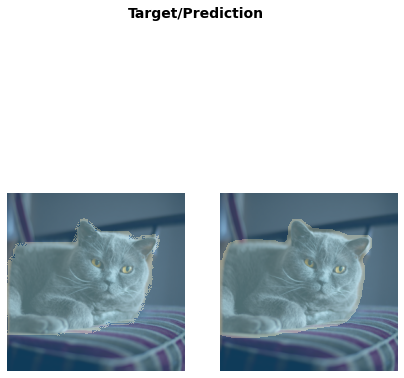

In [34]:
# Show the results
learn.show_results(max_n=1, figsize=(7,8))

In [12]:
# All images
dls = get_data(size=256,bs=64)
learn = Learner(dls,Unet(backbone='resnet50', decoder_use_batchnorm=True, in_chans=3, num_classes=1),loss_func=BCEWithLogitsLossFlat(), metrics=dice)
learn.fit(10)

epoch,train_loss,valid_loss,dice,time
0,0.207089,0.210895,0.913407,00:48


epoch,train_loss,valid_loss,dice,time
0,0.131182,0.120494,0.942359,00:47
1,0.121429,0.141688,0.923356,00:47
2,0.114593,0.152746,0.923707,00:48
3,0.108897,0.119556,0.939554,00:48
4,0.106864,0.139904,0.929850,00:48
5,0.099939,0.112199,0.947368,00:48
6,0.092221,0.106907,0.940744,00:48
7,0.086230,0.105530,0.945255,00:48
8,0.083925,0.105295,0.945281,00:50
9,0.081392,0.105322,0.943727,00:48


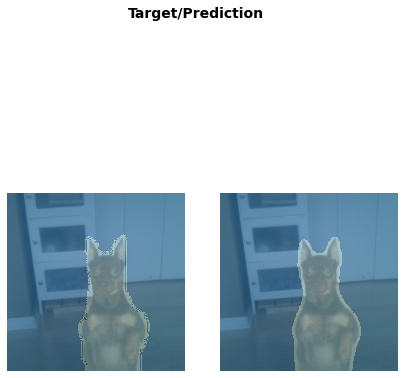

In [13]:
# Show the results
learn.show_results(max_n=1, figsize=(7,8))

## Whole slide images

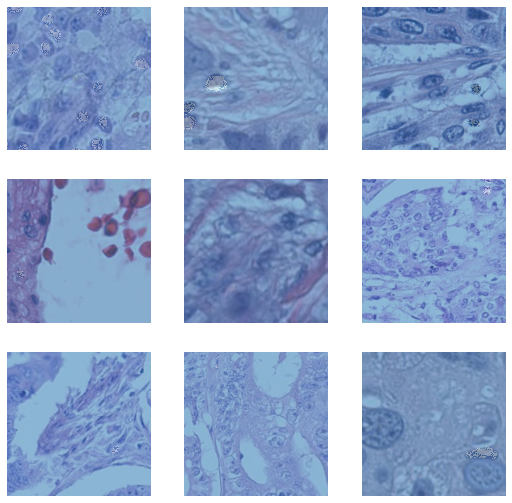

In [8]:
dls = get_data(size=256,bs=64)
dls.show_batch(max_n=9)

In [9]:
wandb_callback = WandbCallback(
    log='all', 
    log_preds=False,
    log_preds_every_epoch=False, 
    log_model=False,
    model_name=None, 
    log_dataset=False,
    dataset_name=None,
    valid_dl=None, 
    n_preds=36,
    seed=12345, 
    reorder=True
)

In [ ]:
# Initialize wandb
wandb.init(project="Bachelor_WSI")

# All images
dls = get_data(size=256,bs=64)
learn = Learner(dls,Unet(backbone='resnet50', decoder_use_batchnorm=True, in_chans=3, num_classes=1),loss_func=BCEWithLogitsLossFlat(), metrics=dice, cbs=[wandb_callback])
learn.fine_tune(7)

wandb: Currently logged in as: marcusnsr (ml-data-sci). Use `wandb login --relogin` to force relogin


epoch,train_loss,valid_loss,dice,time
0,0.470588,0.277866,0.054445,00:35


epoch,train_loss,valid_loss,dice,time
0,0.250184,0.223486,0.084339,00:35
1,0.196984,0.165686,0.261368,00:35
2,0.143004,0.118600,0.240085,00:35


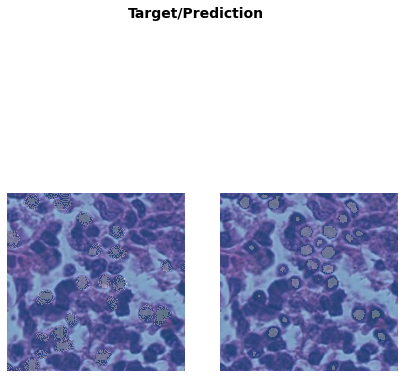

In [14]:
# Show the results
learn.show_results(max_n=1, figsize=(7,8))

In [ ]:
# Initialize wandb
wandb.init(project="Bachelor_WSI")
# All images now with augmentations
dls = get_data(size=256,bs=64)
learn2 = Learner(dls,Unet(backbone='resnet50', decoder_use_batchnorm=True, in_chans=3, num_classes=1),loss_func=BCEWithLogitsLossFlat(), metrics=dice, cbs=[wandb_callback])
learn2.fit(50)

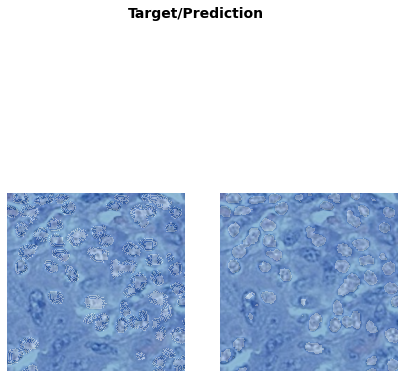

wandb: WARNING (User provided step: 750 is less than current step: 751. Dropping entry: {'epoch': 10, '_timestamp': 1709292777.4209151}).
wandb: WARNING (User provided step: 750 is less than current step: 751. Dropping entry: {'valid_loss': 0.30133193731307983, 'dice': '00:00', '_timestamp': 1709292777.421104}).


In [26]:
# Show the results
learn2.show_results(max_n=1, figsize=(7,8))

# Training just the encoder

In [19]:
def unet_splitter(m): return L(m.encoder,m.decoder).map(params)

In [20]:
dls = get_data(size=256,bs=64)

In [21]:
# All images now with augmentations
learn3 = Learner(dls,Unet(backbone='resnetrs50', decoder_use_batchnorm=True, in_chans=3, num_classes=1),loss_func=BCEWithLogitsLossFlat(), metrics=dice, cbs=[wandb_callback], splitter=unet_splitter)

model.safetensors:   0%|          | 0.00/143M [00:00<?, ?B/s]

In [22]:
learn3.freeze()

In [23]:
# Initialize wandb
wandb.init(project="Bachelor_WSI")
learn3.fit_one_cycle(10,1e-2)

dice,▁▆▇▇▇▇▇▇▇▇▇▇▇▆█▇▇▇▇▇▇▇██▇█▇█▇▆▇█▇▇▇██▇▇█
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
raw_loss,█▅▃▃▂▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_samples_per_sec,█▇▅▄▄▂▃▃▂▃▁▃▂▂▂▁▃▁▃▁▂▂▂▃▂▃▂▃▁▃▂▂▂▂▁▁▂▂▁▁
valid_loss,█▅▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


epoch,train_loss,valid_loss,dice,time
0,0.380998,0.214902,0.090421,00:36
1,0.136787,0.050180,0.255963,00:36
2,0.065937,0.044134,0.263660,00:36
3,0.048686,0.038729,0.276646,00:37
4,0.042885,0.038190,0.290068,00:37
5,0.041357,0.037474,0.278450,00:37
6,0.039312,0.037108,0.291805,00:37
7,0.038072,0.036269,0.278863,00:37
8,0.037305,0.035880,0.289305,00:37
9,0.037059,0.035966,0.289167,00:37


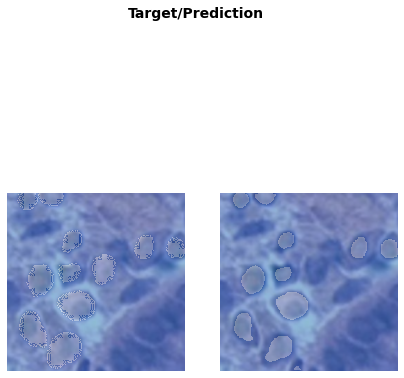

wandb: WARNING Step only supports monotonically increasing values, use define_metric to set a custom x axis. For details see: https://wandb.me/define-metric
wandb: WARNING (User provided step: 749 is less than current step: 750. Dropping entry: {'epoch': 10, '_timestamp': 1709292760.650294}).
wandb: WARNING (User provided step: 749 is less than current step: 750. Dropping entry: {'valid_loss': 0.03596577048301697, 'dice': 0.2891670763492584, '_timestamp': 1709292760.6506102}).


In [25]:
# Show the results
learn3.show_results(max_n=1, figsize=(7,8))